In [1]:
# disable overly verbose tensorflow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_curve, auc

## Import model of interest (change cell below)

In [2]:
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input

In [3]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     train_path = os.path.join(base_dir, 'train+val', 'train')
     valid_path = os.path.join(base_dir, 'train+val', 'valid')

     # instantiate data generators
     datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

     train_gen = datagen.flow_from_directory(train_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(valid_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary')

     return train_gen, val_gen

In [4]:
IMAGE_SIZE = 96

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

input = Input(input_shape)

## Import pretrained model (change cell below)

In [5]:
pretrained = EfficientNetB5(input_shape=input_shape, include_top=False, weights='imagenet')

In [6]:
output = pretrained(input)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(input, output)

# note the lower lr compared to the cnn example
model.compile(SGD(lr=0.001, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

# print a summary of the model on screen
model.summary()

# get the data generators
train_gen, val_gen = get_pcam_generators(r"D:\Project Imaging\Data")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb5 (Functional)  (None, 3, 3, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 28,515,576
Trainable params: 28,342,833
Non-trainable params: 172,743
___________________________________________

C:\Users\bdaen\anaconda3\envs\8p361\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


## Save model and weights (change cell below)

In [7]:
model_name = 'EfficientNetB5'

In [8]:
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)
    
# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

## Train the model

In [9]:
# train the model, note that we define "mini-epochs"
train_steps = train_gen.n//train_gen.batch_size//20
val_steps = val_gen.n//val_gen.batch_size//20

# since the model is trained for only 10 "mini-epochs", i.e. half of the data is
# not used during training
history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=callbacks_list)

C:\Users\bdaen\AppData\Local\Temp\ipykernel_1832\1290848798.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.7158
Epoch 1: val_loss improved from inf to 0.44220, saving model to EfficientNetB5_weights.hdf5
225/225 [==============================] - 762s 3s/step - loss: 0.5433 - accuracy: 0.7158 - val_loss: 0.4422 - val_accuracy: 0.7987
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8174
Epoch 2: val_loss improved from 0.44220 to 0.35709, saving model to EfficientNetB5_weights.hdf5
225/225 [==============================] - 745s 3s/step - loss: 0.4159 - accuracy: 0.8174 - val_loss: 0.3571 - val_accuracy: 0.8475
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8315
Epoch 3: val_loss improved from 0.35709 to 0.32514, saving model to EfficientNetB5_weights.hdf5
225/225 [==============================] - 1060s 5s/step - loss: 0.3845 - accuracy: 0.8315 - val_loss: 0.3251 - val_accuracy: 0.8800
Epoch 4/10
225/225 [===========

## ROC analysis

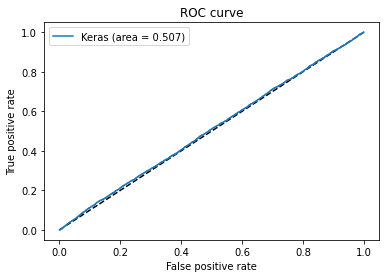

In [10]:
import matplotlib.pyplot as plt

model = tf.keras.models.load_model(weights_filepath)
y_pred = model.predict(val_gen).ravel()
y_true = val_gen.labels

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
from sklearn.metrics import auc
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()